# Time Series Forecasting on Bitcoin

## Helper Functions

In [36]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps against values
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, . vs -
  start : where to start the plot
  end : where to end the plot
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [40]:
import tensorflow as tf
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day

  return mae / mae_naive_no_season

In [42]:
# Evaluation helper
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [48]:
import numpy as np
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # Create a window of specific window_size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # Create a 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [50]:
# Make the train/test splits out of windows
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [52]:
import os

# Implement model checkpoint to save best model
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [55]:
def make_preds(model, input_data):
  """
  Predicts ands squeezes predictions for 1D output.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

# Get Data

In [1]:
# Import most recent data from drive
# Last imported on 11/10/2021
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/tensorflow_course/BTC_USD_2014-11-02_2021-11-09-CoinDesk.csv',
                      parse_dates=["Date"],
                      index_col=["Date"])
df.head(), df.tail(), len(df)

(           Currency  Closing Price (USD)  ...  24h High (USD)  24h Low (USD)
 Date                                      ...                               
 2014-11-02      BTC            331.60083  ...       333.75983      319.04350
 2014-11-03      BTC            324.71833  ...       332.75133      323.06333
 2014-11-04      BTC            332.45666  ...       335.81166      320.93333
 2014-11-05      BTC            336.58500  ...       341.49000      328.56166
 2014-11-06      BTC            346.77500  ...       351.57500      336.02833
 
 [5 rows x 5 columns],
            Currency  Closing Price (USD)  ...  24h High (USD)  24h Low (USD)
 Date                                      ...                               
 2021-11-01      BTC         61200.225752  ...    62331.429905   59520.505066
 2021-11-06      BTC         61469.973676  ...    61559.970200   60168.199228
 2021-11-07      BTC         62924.521859  ...    63120.326920   61410.068562
 2021-11-08      BTC         67633.6477

In [13]:
# Reduce df to closing price and data
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-02,331.60083
2014-11-03,324.71833
2014-11-04,332.45666
2014-11-05,336.58500
2014-11-06,346.77500


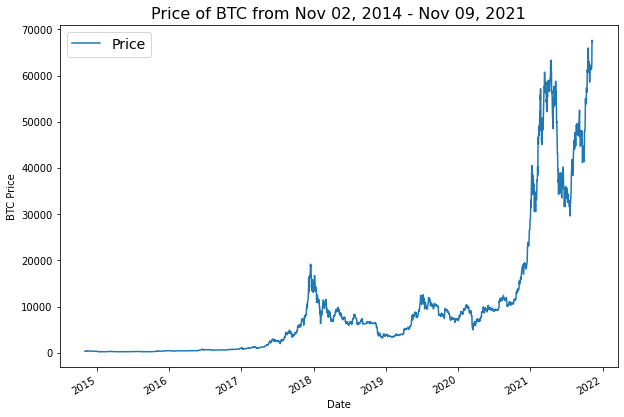

In [15]:
# Plot price
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of BTC from Nov 02, 2014 - Nov 09, 2021", fontsize=16)
plt.legend(fontsize=14);

In [16]:
# Get dates and prices as arrays
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:5], prices[:5], len(timesteps), len(prices)

(array(['2014-11-02T00:00:00.000000000', '2014-11-03T00:00:00.000000000',
        '2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  ]),
 2561,
 2561)

In [17]:
# Create train and test splits chronologically

split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2048, 513, 2048, 513)

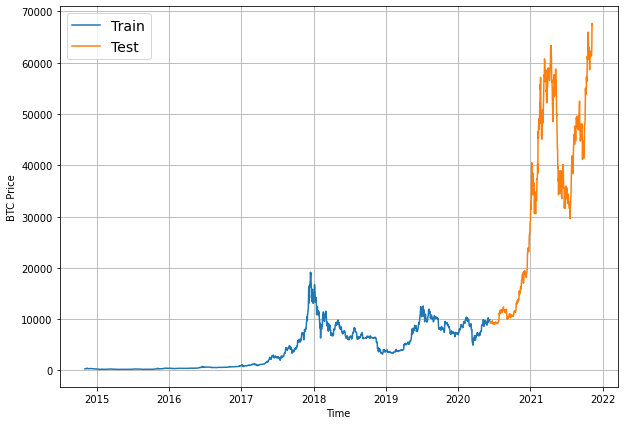

In [30]:
# Plot train and test split
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, format="-", label="Train" )
plot_time_series(X_test, y_test, format="-", label="Test")

# Models

## Model 0: Baseline, Naive Forecasting

In [29]:
# Create naive forecast, predicts last value as current value
naive_forecast = y_test[:-1]

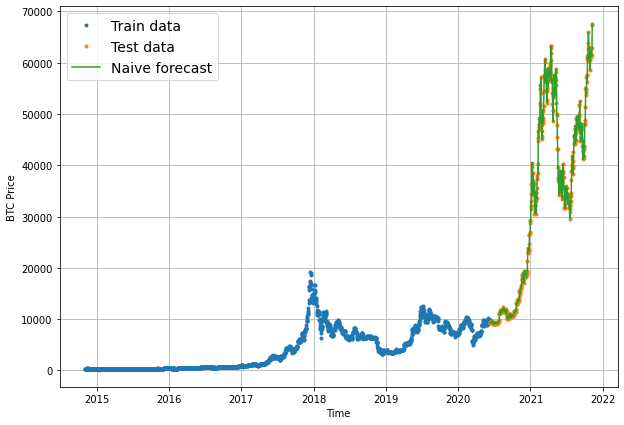

In [35]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

In [41]:
# Evaluate model
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 948.0025,
 'mape': 2.6159828,
 'mase': 0.99846536,
 'mse': 2124905.0,
 'rmse': 1457.7054}

## Convert Data Into Windows/Horizons for Real Models

In [46]:
# 1 week to predict next days price
HORIZON = 1
WINDOW_SIZE = 7

In [49]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2554, 2554)

In [51]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2043, 511, 2043, 511)

## Model 1: Dense Model

In [53]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                     
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # save best model with checkpoint

Epoch 1/100
16/16 [==============================] - 4s 75ms/step - loss: 1057.4393 - mae: 1057.4393 - val_loss: 4340.7368 - val_mae: 4340.7368
Epoch 2/100
16/16 [==============================] - 1s 43ms/step - loss: 375.8563 - mae: 375.8563 - val_loss: 2339.2771 - val_mae: 2339.2771
Epoch 3/100
16/16 [==============================] - 1s 42ms/step - loss: 253.9307 - mae: 253.9307 - val_loss: 2011.2892 - val_mae: 2011.2892
Epoch 4/100
16/16 [==============================] - 1s 44ms/step - loss: 232.0125 - mae: 232.0125 - val_loss: 1701.4579 - val_mae: 1701.4579
Epoch 5/100
16/16 [==============================] - 1s 45ms/step - loss: 223.5035 - mae: 223.5035 - val_loss: 1661.1809 - val_mae: 1661.1809
Epoch 6/100
16/16 [==============================] - 1s 45ms/step - loss: 217.3392 - mae: 217.3392 - val_loss: 1558.5112 - val_mae: 1558.5112
Epoch 7/100
16/16 [==============================] - 1s 45ms/step - loss: 212.3137 - mae: 212.3137 - val_loss: 1519.6842 - val_mae: 1519.6842
Epoc

In [54]:
# Load in best performing model and evaluate
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 3ms/step - loss: 957.8994 - mae: 957.8994


[957.8994140625, 957.8994140625]

In [57]:
# Make predictions
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds)

511

In [58]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 957.89935,
 'mape': 2.6403,
 'mase': 1.0069262,
 'mse': 2182468.2,
 'rmse': 1477.318}

In [59]:
# Compare to naive
naive_results

{'mae': 948.0025,
 'mape': 2.6159828,
 'mase': 0.99846536,
 'mse': 2124905.0,
 'rmse': 1457.7054}

## Converting Data Into Multivariate

In [60]:
# Block reward values
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [61]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(615, 2017)

In [63]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head(), bitcoin_prices_block.tail()

(                Price block_reward
 Date                              
 2014-11-02  331.60083           25
 2014-11-03  324.71833           25
 2014-11-04  332.45666           25
 2014-11-05  336.58500           25
 2014-11-06  346.77500           25,                    Price block_reward
 Date                                 
 2021-11-01  61200.225752         6.25
 2021-11-06  61469.973676         6.25
 2021-11-07  62924.521859         6.25
 2021-11-08  67633.647720         6.25
 2021-11-09  67292.137614         6.25)

In [64]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE)
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-02,331.60083,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,324.71833,25,331.60083,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,332.45666,25,324.71833,331.60083,NaN,NaN,NaN,NaN,NaN
2014-11-05,336.58500,25,332.45666,324.71833,331.60083,NaN,NaN,NaN,NaN
2014-11-06,346.77500,25,336.58500,332.45666,324.71833,331.60083,NaN,NaN,NaN
2014-11-07,344.81166,25,346.77500,336.58500,332.45666,324.71833,331.60083,NaN,NaN
2014-11-08,343.06500,25,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083,NaN
2014-11-09,358.50166,25,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083
2014-11-10,368.07666,25,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833


In [67]:
# Conver to X & y, and remove the NaN's 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1  ...     Price+6     Price+7
 Date                                  ...                        
 2014-11-09          25.0  343.065002  ...  324.718323  331.600830
 2014-11-10          25.0  358.501648  ...  332.456665  324.718323
 2014-11-11          25.0  368.076660  ...  336.584991  332.456665
 2014-11-12          25.0  376.996674  ...  346.774994  336.584991
 2014-11-13          25.0  442.106659  ...  344.811646  346.774994
 
 [5 rows x 8 columns], Date
 2014-11-09    358.501648
 2014-11-10    368.076660
 2014-11-11    376.996674
 2014-11-12    442.106659
 2014-11-13    389.003326
 Name: Price, dtype: float32)

In [68]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2043, 2043, 511, 511)

## Model 2: Dense (Multivariate)

In [74]:
# Rebuild model 1, use multivariate input
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_ex

In [75]:
# Make sure best model is loaded and evaluate
model_2 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_2.evaluate(X_test, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 952.3300


952.3300170898438

In [76]:
# Make predictions on multivariate data
model_2_preds = tf.squeeze(model_2.predict(X_test))

In [77]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_2_preds)
model_2_results

{'mae': 952.3299,
 'mape': 2.6276119,
 'mase': 1.0010717,
 'mse': 2161832.0,
 'rmse': 1470.3169}

In [78]:
model_1_results, naive_results

({'mae': 957.89935,
  'mape': 2.6403,
  'mase': 1.0069262,
  'mse': 2182468.2,
  'rmse': 1477.318},
 {'mae': 948.0025,
  'mape': 2.6159828,
  'mase': 0.99846536,
  'mse': 2124905.0,
  'rmse': 1457.7054})

## Model 3: N-BEATS

In [79]:
# Rebuilding the N-Beats model from https://arxiv.org/pdf/1905.10437.pdf

### Building N-BEATS Block

In [80]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Prepare Data for N-BEATS

In [81]:
HORIZON = 1
WINDOW_SIZE = 7

In [82]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-09,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083
2014-11-10,368.07666,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833
2014-11-11,376.99666,368.07666,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666
2014-11-12,442.10666,376.99666,368.07666,358.50166,343.06500,344.81166,346.77500,336.58500
2014-11-13,389.00333,442.10666,376.99666,368.07666,358.50166,343.06500,344.81166,346.77500


In [83]:
# Get X and y
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2043, 2043, 511, 511)

In [84]:
# Convert into tf datasets

# Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### N-BEATS Hyperparameters

In [85]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 500
N_NEURONS = 51
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Build Model

In [90]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 3. Put the stack model together
model_3 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_3_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_3.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00353: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00453: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [91]:
# Evaluate N-BEATS model on the test dataset
model_3.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 970.2450 - mae: 970.2450 - mse: 2259142.5000


[970.2449951171875, 970.2449951171875, 2259142.5]

In [92]:
# Make predictions with N-BEATS model
model_3_preds = make_preds(model_3, test_dataset)

In [93]:
# Evaluate N-BEATS model predictions
model_3_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_3_preds)
model_3_results

{'mae': 970.245,
 'mape': 2.6800082,
 'mase': 1.0199038,
 'mse': 2259142.5,
 'rmse': 1503.0444}

In [94]:
naive_results

{'mae': 948.0025,
 'mape': 2.6159828,
 'mase': 0.99846536,
 'mse': 2124905.0,
 'rmse': 1457.7054}

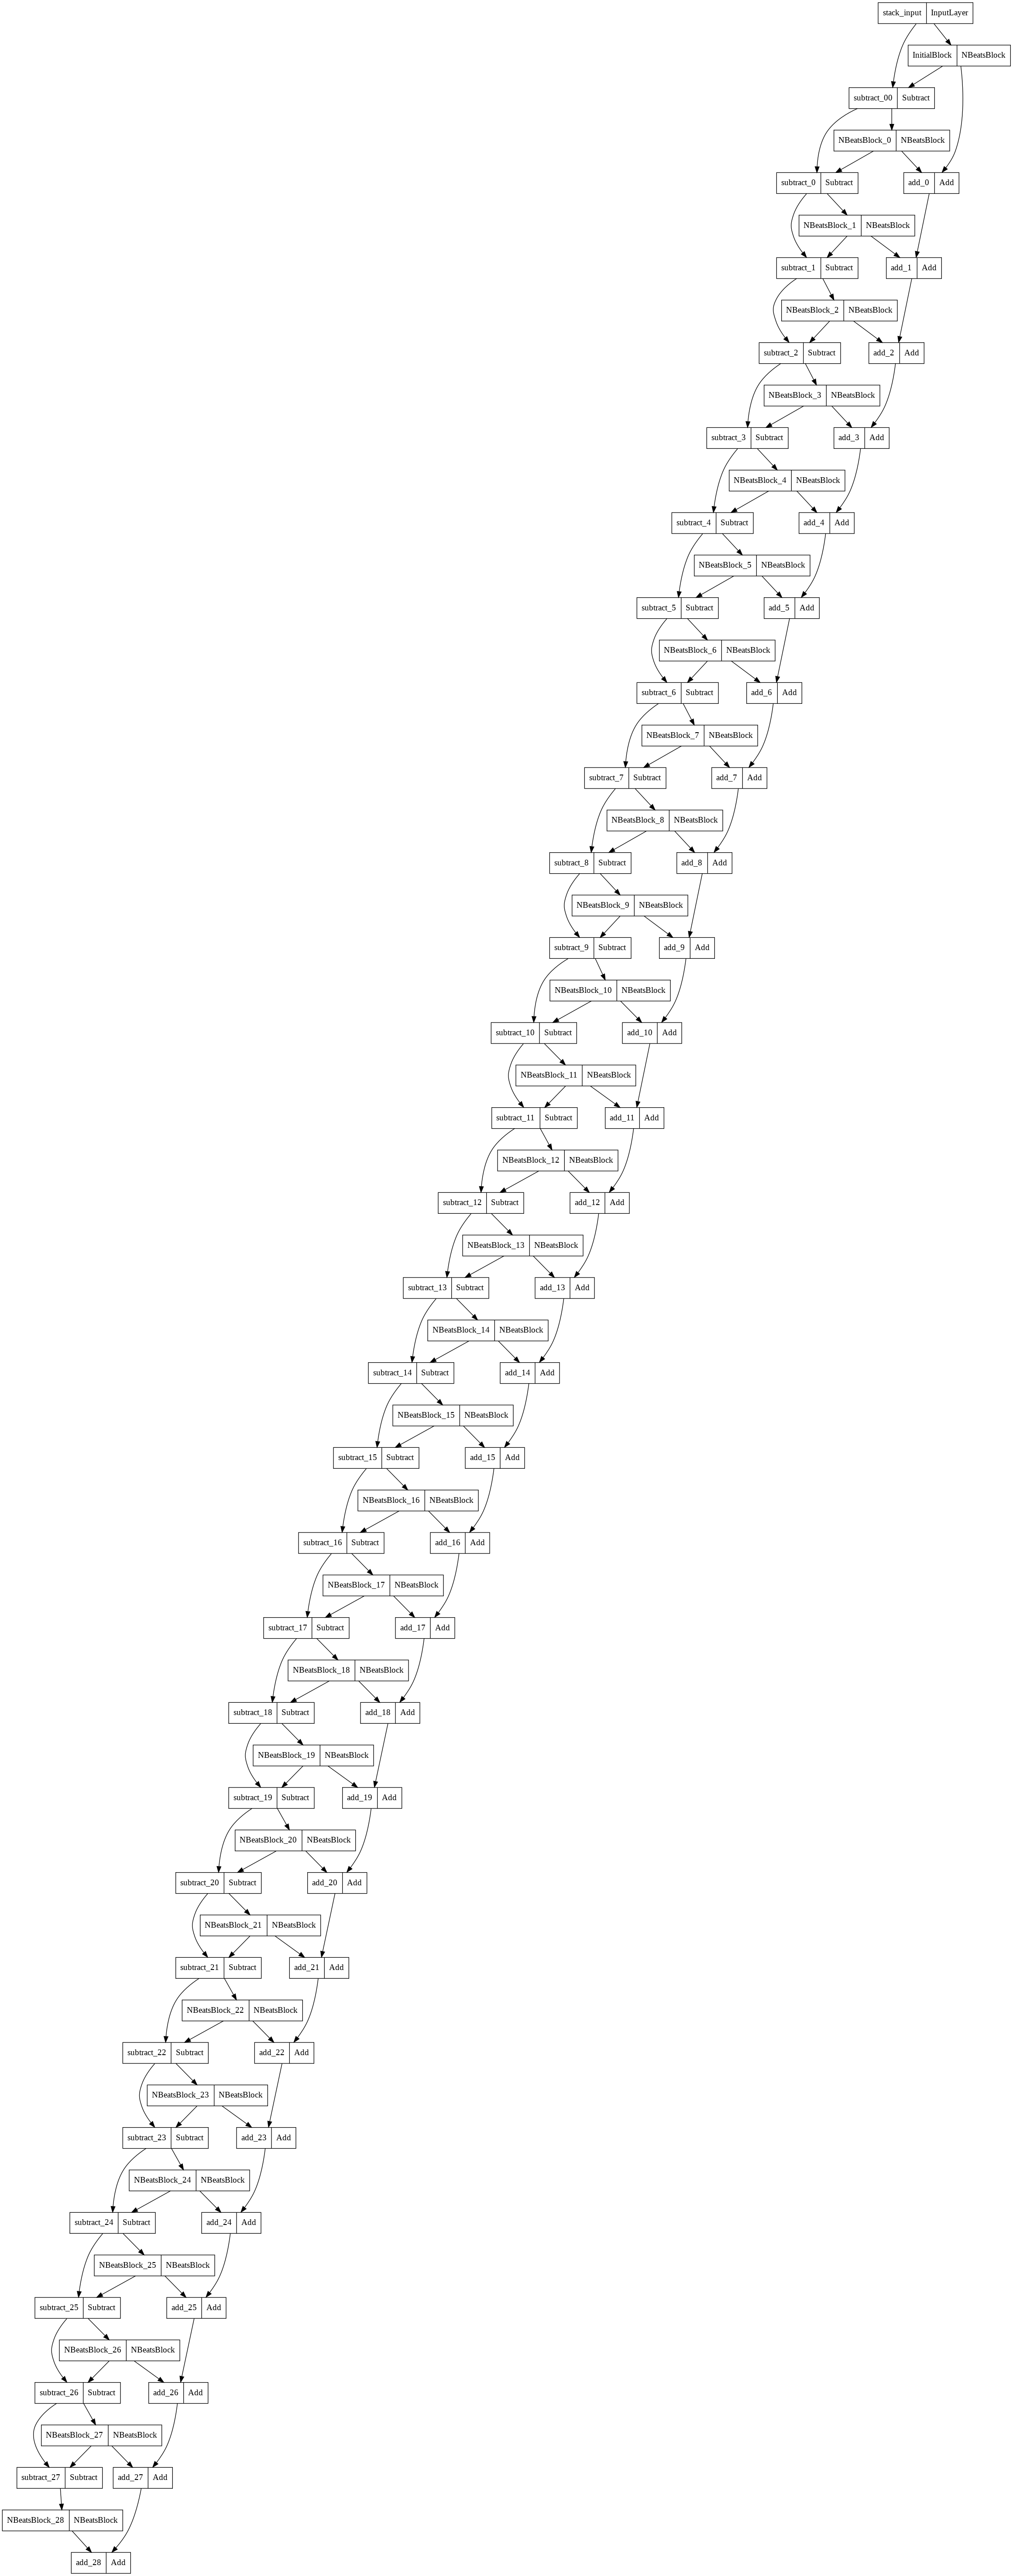

In [95]:
# Plot the N-BEATS model
from tensorflow.keras.utils import plot_model
plot_model(model_3)

## Model 4: Ensemble

In [96]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
  """
  ensemble_models = []

  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction interval estimation later
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [97]:
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00333: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00884: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00984: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00640: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00740: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00406: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00508: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 0

In [98]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [99]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

In [100]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 949.6981,
 'mape': 2.6197934,
 'mase': 0.99830526,
 'mse': 2165099.2,
 'rmse': 1471.4276}

In [101]:
naive_results

{'mae': 948.0025,
 'mape': 2.6159828,
 'mase': 0.99846536,
 'mse': 2124905.0,
 'rmse': 1457.7054}

### Prediction Interval

In [102]:
# Find upper and lower bounds of ensemble predictions, 95%
def get_upper_lower(preds):
  
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std

  # Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

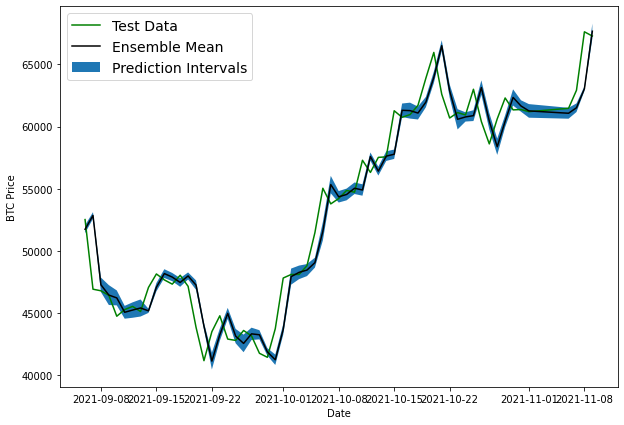

In [103]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_mean = np.mean(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=450
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_mean[offset:], "k-", label="Ensemble Mean")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model Comparison

In [104]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_multivariate": model_2_results,
                              "model_3_NBEATs": model_3_results,
                              "model_4_ensemble": ensemble_results}).T

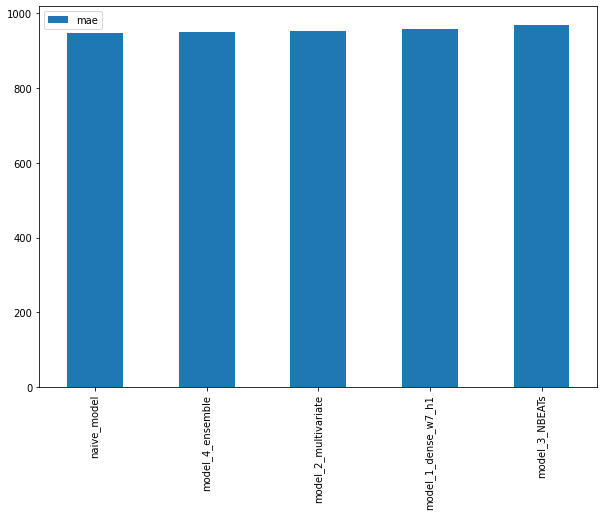

In [105]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");